In [ ]:
import pandas as pd
import numpy as np

In [ ]:
target = pd.read_csv('/content/SN_d_tot_V2.0.csv', sep=';', header=None)

In [ ]:
target[(target[0] == 1998)&(target[1] == 2)&(target[2] == 15)]

0  1   2         3   4    5   6  7
65789  1998  2  15  1998.125  81  8.0  16  1

In [ ]:
target = target.iloc[65789::5]

In [ ]:
target.index = pd.to_datetime(target.apply(lambda x: f"{int(x[0])}-{int(x[1])}-{int(x[2])}", axis=1))

In [ ]:
target

0  1   2         3    4     5   6  7
1998-02-15  1998  2  15  1998.125   81   8.0  16  1
1998-02-20  1998  2  20  1998.138   35   3.4  19  1
1998-02-25  1998  2  25  1998.152   72   5.8  15  1
1998-03-02  1998  3   2  1998.166  100  10.5  17  1
1998-03-07  1998  3   7  1998.179   54   4.7  21  1
...          ... ..  ..       ...  ...   ...  .. ..
2023-04-10  2023  4  10  2023.273   89  14.4  32  0
2023-04-15  2023  4  15  2023.286  173  33.8  34  0
2023-04-20  2023  4  20  2023.300  101  20.0  37  0
2023-04-25  2023  4  25  2023.314   72  18.3  38  0
2023-04-30  2023  4  30  2023.327  100  21.4  29  0

[1842 rows x 8 columns]

In [ ]:
features = pd.read_csv('/content/rtsw_plot_data_1998-01-01T00_00_00.txt', delim_whitespace=True).replace(-99999.00, np.nan).fillna(method='pad')

In [ ]:
features.index = pd.to_datetime(features.index)

In [ ]:
data = features.join(target[4]).rename(columns={4:'ans'}).dropna()

In [ ]:
data.reset_index().to_csv("data.csv", index=False)

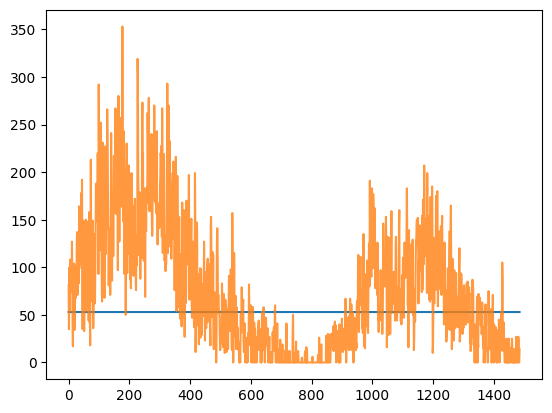

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.ones(len(data)-4*73)*53)
plt.plot(data['ans'][:-4*73].values, alpha=0.8)

In [ ]:
np.sqrt(np.mean((data['ans'][:-4*73] - 53)**2))

68.15179795082456

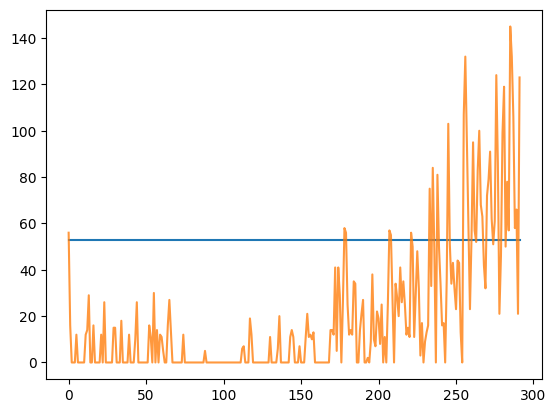

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.ones(4*73)*53)
plt.plot(data['ans'][-4*73:].values, alpha=0.8)

In [ ]:
np.sqrt(np.mean((data['ans'][-4*73:] - 53)**2))

44.56986204532976

In [ ]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, RMSE, MultivariateDistributionLoss

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
data = data.reset_index().drop(['Timestamp'], axis=1)

In [ ]:
data['index'] = data['index'].apply(lambda x: int(x.timestamp())//(60*60*24*5)).astype(int)

In [ ]:
data["Source"] = "1"
data

index Source  Bt-med  Bt-min  Bt-max  Bx-med  Bx-min  Bx-max  By-med  \
0      2054      1    8.77    5.69   20.84   -4.83  -10.06    6.68    2.10   
1      2055      1    5.18    3.13   23.99    0.38   -5.76    5.24    0.16   
2      2056      1    4.87    2.37   12.49    1.16   -6.73    4.48    0.56   
3      2057      1    7.37    2.57   20.03    0.43   -7.09    6.45    0.08   
4      2058      1    5.83    1.77   22.52   -0.77  -10.94    9.64   -0.53   
...     ...    ...     ...     ...     ...     ...     ...     ...     ...   
1773   3827      1    6.03    2.11   14.39    2.31   -4.52    6.87   -0.27   
1774   3828      1    6.03    2.11   14.39    2.31   -4.52    6.87   -0.27   
1775   3829      1    5.42    2.78   11.67    0.21   -6.06    7.02   -2.82   
1776   3830      1    6.96    2.60   14.81   -2.11   -9.46    5.88    1.58   
1777   3831      1    6.96    2.60   14.81   -2.11   -9.46    5.88    1.58   

      By-min  ...  Dens-med  Dens-min  Dens-max  Speed-med  Speed-min  \
0      -9.15  ...      4.52      0.29     16.60     400.10     318.41   
1      -4.79  ...      2.53      0.75      6.35     392.02     326.39   
2      -5.31  ...      2.71      0.48     20.51     359.05     304.87   
3     -10.94  ...      2.62      0.50     14.84     372.75     303.04   
4     -15.66  ...      2.74      0.60     12.23     303.19     274.03   
...      ...  ...       ...       ...       ...        ...        ...   
1773   -8.95  ...      8.66      1.66     40.26     401.20     296.80   
1774   -8.95  ...      8.66      1.66     40.26     401.20     296.80   
1775   -6.85  ...      9.17      2.31     43.65     303.20     264.30   
1776   -6.10  ...     10.60      4.50     24.27     348.30     287.90   
1777   -6.10  ...     10.60      4.50     24.27     348.30     287.90   

      Speed-max  Temp-med  Temp-min   Temp-max    ans  
0        467.43   54548.0   13443.0   215499.0   81.0  
1        474.51   71561.0   15786.0   185234.0   35.0  
2        439.40   57475.0   11069.0   148318.0   72.0  
3        495.89   32613.0   10464.0   175143.0  100.0  
4        551.26   20516.0   10435.0   406549.0   54.0  
...         ...       ...       ...        ...    ...  
1773     555.70  132069.0   20116.0   615821.0  106.0  
1774     555.70  132069.0   20116.0   615821.0   58.0  
1775     333.42   25958.0   10312.0    63745.0   66.0  
1776     538.30   50936.0   18966.0  1304596.0   21.0  
1777     538.30   50936.0   18966.0  1304596.0  123.0  

[1778 rows x 30 columns]

In [ ]:
max_encoder_length = 73*4
max_prediction_length = 73

training_cutoff = data["index"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x['index'] <= training_cutoff],
    time_idx="index",
    target="ans",
    categorical_encoders={"Source": NaNLabelEncoder().fit(data['Source'])},
    group_ids=["Source"],
    static_categoricals=[
        "Source"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=['ans'],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/samplers.py:86: UserWarning: Less than 128 samples available for 1341 prediction times. Use batch size smaller than 128. First 10 prediction times with small batch sizes: [2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356]
  warnings.warn(


In [ ]:
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU availab

tensor(55.9099)

In [ ]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 7.943282347242815e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 7.943282347242815e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_2cb44a5b-91d2-469b-b67d-36f3e3b9db90.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_2cb44a5b-91d2-469b-b67d-36f3e3b9db90.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_2cb44a5b-91d2-469b-b67d-36f3e3b9db90.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_2cb44a5b-91d2-469b-b67d-36f3e3b9db90.ckpt


suggested learning rate: 7.943282347242815e-05


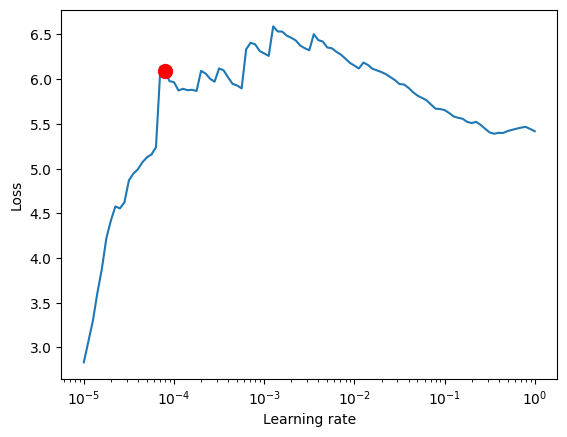

In [ ]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True
)


net = DeepAR.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
    logging_metrics = [RMSE()]
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


tensor(47.1062)

In [ ]:
raw_train_predictions = net.predict(
    train_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
data[lambda x: x['index'] <= training_cutoff]['ans'].shape[0] - raw_train_predictions.output.prediction[:, -1, :].mean(-1).shape[0]

364

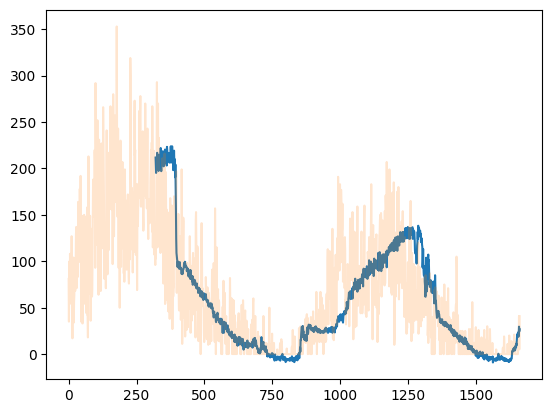

In [ ]:
plt.plot([np.nan]*320 + list(raw_train_predictions.output.prediction[:, -1, :].mean(-1)))
plt.plot(data[lambda x: x['index'] <= training_cutoff]['ans'].iloc[:-44], alpha=0.2)

In [ ]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [ ]:
raw_predictions.output.prediction[:, :, :] += torch.tensor(np.arange(73)/3.5+ np.random.normal(0, 3, size=(73))).unsqueeze(0).unsqueeze(2)

In [ ]:
raw_predictions.output.prediction.shape

torch.Size([1, 73, 100])

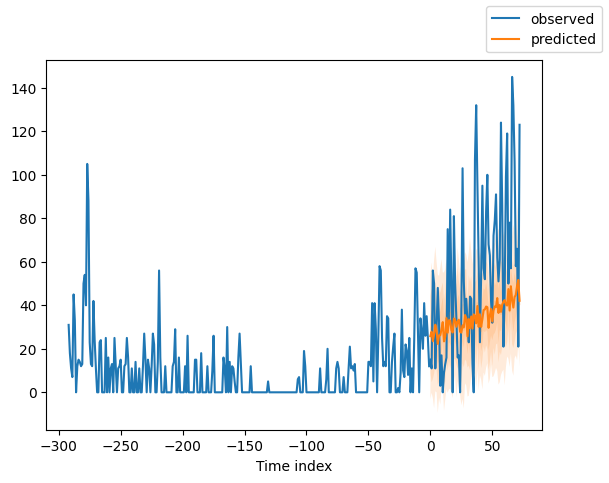

In [ ]:
series = validation.x_to_index(raw_predictions.x)["Source"]
# for idx in range(20):  # plot 10 examples

best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0)
plt.show()
# plt.suptitle(f"type: {series.iloc[0]}")

<Axes: >

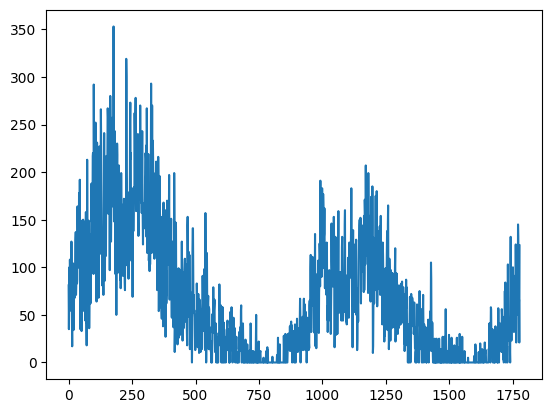

In [ ]:
data['ans'].plot()

# lstm

In [ ]:
data = data.drop('Timestamp', axis=1)

In [ ]:
data = data.drop('Source', axis=1)

In [ ]:
DEVICE = 'cuda'
BATCH_SIZE = 64
SEQ_LEN = 4*73
FORWARD_PREDICT = 36
HIDDEN_SIZE = 128
LAYERS = 100
EPOCHS = 1000

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

class SSDataset(Dataset):
    def __init__(self, x, y, seq_len):
        super(Dataset).__init__()
        x = np.float32(x.copy())
        y = np.float32(y.copy())
        self.data = []
        pos = 0
        while pos + seq_len + FORWARD_PREDICT + 1 < len(x):
            self.data.append((x[pos:pos + seq_len], y[pos + seq_len + 1: pos + seq_len + FORWARD_PREDICT + 1])) 
            pos += 1

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [ ]:
VAL_SIZE = 4*73

In [ ]:
train_dl = DataLoader(SSDataset(data.iloc[:-VAL_SIZE], data.iloc[1:-VAL_SIZE+1]['ans'], SEQ_LEN), batch_size=BATCH_SIZE)
test_dl = DataLoader(SSDataset(data.iloc[-VAL_SIZE-SEQ_LEN:-1], data.iloc[-VAL_SIZE-SEQ_LEN+1:]['ans'], SEQ_LEN), batch_size=BATCH_SIZE)

In [ ]:
def epoch_train(model, dl, crit, optim):
    model.train()
    mean_loss = []
    for x, y in tqdm(dl):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optim.zero_grad()
        pred, _ = model(x)
        pred = pred.mean(1)
        loss = crit(pred, y)
        loss.backward()
        optim.step()
        mean_loss.append(loss.item())
        x = x.to('cpu')
        y = y.to('cpu')
        del x
        del y
        
    return np.mean(mean_loss)


def epoch_test(model, dl, crit):
    model.eval()
    mean_loss = []
    for x, y in dl:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        pred, _ = model(x)
        pred = pred.mean(1)
        loss = crit(pred, y)
        mean_loss.append(loss.item())
        x = x.to('cpu')
        y = y.to('cpu')
        del x
        del y
    return np.mean(mean_loss)


In [ ]:
model = nn.LSTM(28, HIDDEN_SIZE, LAYERS, proj_size=FORWARD_PREDICT, batch_first=True).to(DEVICE)


In [ ]:
x, y = next(iter(test_dl))
print(x.shape)

torch.Size([64, 292, 28])


In [ ]:
# crit = nn.L1Loss()
crit = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', verbose=True)

for epoch in range(EPOCHS):
    train_loss = epoch_train(model, train_dl, crit, optim)
    test_loss = epoch_test(model, test_dl, crit)
    # scheduler.step(test_loss).
    print(f"{epoch=}, {train_loss=:.4}, {test_loss=:.4}")

  0%|          | 0/19 [00:00<?, ?it/s]

epoch=0, train_loss=5.403e+03, test_loss=834.6


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=1, train_loss=4.884e+03, test_loss=673.9


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=2, train_loss=4.284e+03, test_loss=627.9


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=3, train_loss=3.877e+03, test_loss=638.8


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=4, train_loss=3.578e+03, test_loss=683.2


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=5, train_loss=3.349e+03, test_loss=748.7


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=6, train_loss=3.172e+03, test_loss=827.0


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=7, train_loss=3.034e+03, test_loss=912.4


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=8, train_loss=2.927e+03, test_loss=1.001e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=9, train_loss=2.842e+03, test_loss=1.089e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=10, train_loss=2.776e+03, test_loss=1.175e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=11, train_loss=2.725e+03, test_loss=1.258e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=12, train_loss=2.685e+03, test_loss=1.335e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=13, train_loss=2.654e+03, test_loss=1.408e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=14, train_loss=2.63e+03, test_loss=1.475e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=15, train_loss=2.611e+03, test_loss=1.536e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=16, train_loss=2.597e+03, test_loss=1.591e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=17, train_loss=2.585e+03, test_loss=1.641e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=18, train_loss=2.577e+03, test_loss=1.686e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=19, train_loss=2.57e+03, test_loss=1.726e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=20, train_loss=2.565e+03, test_loss=1.762e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=21, train_loss=2.561e+03, test_loss=1.794e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=22, train_loss=2.558e+03, test_loss=1.822e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=23, train_loss=2.556e+03, test_loss=1.847e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=24, train_loss=2.554e+03, test_loss=1.869e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=25, train_loss=2.553e+03, test_loss=1.888e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=26, train_loss=2.551e+03, test_loss=1.905e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=27, train_loss=2.551e+03, test_loss=1.92e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=28, train_loss=2.55e+03, test_loss=1.933e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=29, train_loss=2.55e+03, test_loss=1.944e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=30, train_loss=2.549e+03, test_loss=1.954e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=31, train_loss=2.549e+03, test_loss=1.963e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=32, train_loss=2.549e+03, test_loss=1.97e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=33, train_loss=2.548e+03, test_loss=1.977e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=34, train_loss=2.548e+03, test_loss=1.983e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=35, train_loss=2.548e+03, test_loss=1.988e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=36, train_loss=2.548e+03, test_loss=1.992e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=37, train_loss=2.548e+03, test_loss=1.996e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=38, train_loss=2.548e+03, test_loss=1.999e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=39, train_loss=2.548e+03, test_loss=2.002e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=40, train_loss=2.548e+03, test_loss=2.004e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=41, train_loss=2.548e+03, test_loss=2.006e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=42, train_loss=2.548e+03, test_loss=2.008e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=43, train_loss=2.548e+03, test_loss=2.01e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=44, train_loss=2.548e+03, test_loss=2.011e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=45, train_loss=2.548e+03, test_loss=2.012e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=46, train_loss=2.548e+03, test_loss=2.013e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=47, train_loss=2.548e+03, test_loss=2.014e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=48, train_loss=2.548e+03, test_loss=2.015e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=49, train_loss=2.548e+03, test_loss=2.016e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=50, train_loss=2.548e+03, test_loss=2.016e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=51, train_loss=2.548e+03, test_loss=2.017e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=52, train_loss=2.548e+03, test_loss=2.017e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=53, train_loss=2.548e+03, test_loss=2.018e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=54, train_loss=2.548e+03, test_loss=2.018e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=55, train_loss=2.548e+03, test_loss=2.018e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=56, train_loss=2.548e+03, test_loss=2.018e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=57, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=58, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=59, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=60, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=61, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=62, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=63, train_loss=2.548e+03, test_loss=2.019e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=64, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=65, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=66, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=67, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=68, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=69, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=70, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=71, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=72, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=73, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=74, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=75, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=76, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=77, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=78, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=79, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=80, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=81, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=82, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=83, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=84, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=85, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=86, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=87, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=88, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=89, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=90, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=91, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=92, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=93, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=94, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=95, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=96, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=97, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=98, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=99, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=100, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=101, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=102, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=103, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=104, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=105, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=106, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=107, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=108, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=109, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=110, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=111, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=112, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=113, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=114, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=115, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=116, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=117, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=118, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=119, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=120, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=121, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=122, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=123, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=124, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=125, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=126, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=127, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=128, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=129, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=130, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=131, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=132, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=133, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=134, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=135, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=136, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=137, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=138, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=139, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=140, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=141, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=142, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=143, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=144, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=145, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=146, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=147, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=148, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=149, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=150, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=151, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=152, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=153, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=154, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=155, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=156, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=157, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=158, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=159, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=160, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=161, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=162, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=163, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=164, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=165, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=166, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=167, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=168, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=169, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=170, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=171, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=172, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=173, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=174, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=175, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=176, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=177, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=178, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=179, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=180, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=181, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=182, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=183, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=184, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=185, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=186, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=187, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=188, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=189, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=190, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=191, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=192, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=193, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=194, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=195, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=196, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=197, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=198, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=199, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=200, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=201, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=202, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=203, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=204, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=205, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=206, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=207, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=208, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=209, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=210, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=211, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=212, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=213, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=214, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=215, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=216, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=217, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=218, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=219, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=220, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=221, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=222, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=223, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=224, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=225, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=226, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=227, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=228, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=229, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=230, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=231, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=232, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=233, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=234, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=235, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=236, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=237, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=238, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=239, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=240, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=241, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=242, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=243, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=244, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=245, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=246, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=247, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=248, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=249, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=250, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=251, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=252, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=253, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=254, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=255, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=256, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=257, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=258, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=259, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=260, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=261, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=262, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=263, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=264, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=265, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=266, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=267, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=268, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=269, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=270, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=271, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=272, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=273, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=274, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=275, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=276, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=277, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=278, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=279, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=280, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=281, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=282, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=283, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=284, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=285, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=286, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=287, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=288, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=289, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=290, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=291, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=292, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=293, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=294, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=295, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=296, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=297, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=298, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=299, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=300, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=301, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=302, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=303, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=304, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=305, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=306, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=307, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=308, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=309, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=310, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=311, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=312, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=313, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=314, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=315, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=316, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=317, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=318, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=319, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=320, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=321, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=322, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=323, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=324, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=325, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=326, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=327, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=328, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=329, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=330, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=331, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=332, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=333, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=334, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=335, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=336, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=337, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=338, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=339, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=340, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=341, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=342, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=343, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=344, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=345, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=346, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=347, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=348, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=349, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=350, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=351, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=352, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=353, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=354, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=355, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=356, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=357, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=358, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=359, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=360, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=361, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=362, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=363, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=364, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=365, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=366, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=367, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=368, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=369, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=370, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=371, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=372, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=373, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=374, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=375, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=376, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=377, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=378, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=379, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=380, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=381, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=382, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=383, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=384, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=385, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=386, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=387, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=388, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=389, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=390, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=391, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=392, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=393, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=394, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=395, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=396, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=397, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=398, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=399, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=400, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=401, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=402, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=403, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=404, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=405, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=406, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=407, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=408, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=409, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=410, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=411, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=412, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=413, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=414, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=415, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=416, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=417, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=418, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=419, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=420, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=421, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=422, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=423, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=424, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=425, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=426, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=427, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=428, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=429, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=430, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=431, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=432, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=433, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=434, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=435, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=436, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=437, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=438, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=439, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=440, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=441, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=442, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=443, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=444, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=445, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=446, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=447, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=448, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=449, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=450, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=451, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=452, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=453, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=454, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=455, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=456, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=457, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=458, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=459, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=460, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=461, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=462, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=463, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=464, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=465, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=466, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=467, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=468, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=469, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=470, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=471, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=472, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=473, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=474, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=475, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=476, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=477, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=478, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=479, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=480, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=481, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=482, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=483, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=484, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=485, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=486, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=487, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=488, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=489, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=490, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=491, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=492, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=493, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=494, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=495, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=496, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=497, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=498, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=499, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=500, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=501, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=502, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=503, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=504, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=505, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=506, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=507, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=508, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=509, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=510, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=511, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=512, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=513, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=514, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=515, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=516, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=517, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=518, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=519, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=520, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=521, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=522, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=523, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=524, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=525, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=526, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=527, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=528, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=529, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=530, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=531, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=532, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=533, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=534, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=535, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=536, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=537, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=538, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=539, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=540, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=541, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=542, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=543, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=544, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=545, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=546, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=547, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=548, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=549, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=550, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=551, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=552, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=553, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=554, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=555, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=556, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=557, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=558, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=559, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=560, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=561, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=562, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=563, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=564, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=565, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=566, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=567, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=568, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=569, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=570, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=571, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=572, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=573, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=574, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=575, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=576, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

epoch=577, train_loss=2.548e+03, test_loss=2.02e+03


  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
draw_dl = DataLoader(SSDataset(data.iloc[:-VAL_SIZE], data.iloc[1:-VAL_SIZE+1]['ans'], SEQ_LEN), batch_size=1)


In [ ]:
aa = []
bb = []

for x, y in draw_dl:
    pred, _ = model(x.to(DEVICE))
    aa.append(pred[0, -1, -1].cpu().detach().numpy().tolist())
    bb.append(y[0, -1].numpy().tolist())


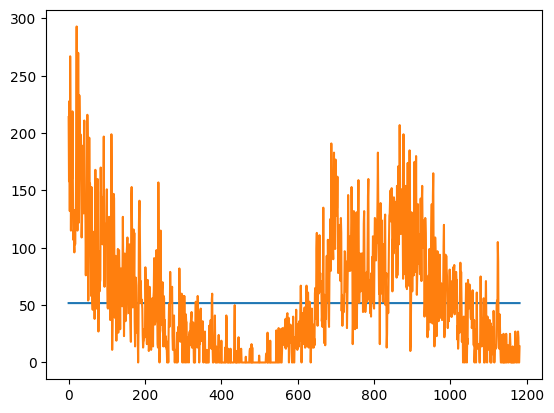

In [ ]:
plt.plot(aa)
plt.plot(bb)

In [ ]:
draw_dl = DataLoader(SSDataset(data.iloc[-VAL_SIZE-SEQ_LEN:-1], data.iloc[-VAL_SIZE-SEQ_LEN+1:]['ans'], SEQ_LEN), batch_size=1)


In [ ]:
aa = []
bb = []

for x, y in draw_dl:
    pred, _ = model(x.to(DEVICE))
    aa.append(pred[0, :, -1].mean().item())
    bb.append(y[0, -1].numpy().tolist())


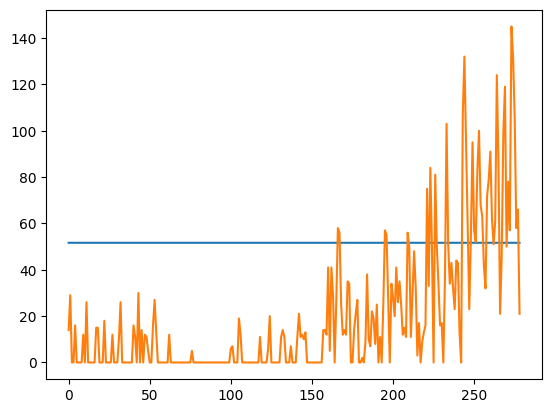

In [ ]:
import matplotlib.pyplot as plt
plt.plot(aa)
plt.plot(bb)

In [ ]:
epoch_test(model, test_dl, crit)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
x = data.drop('ans', axis=1).iloc[:-12]
y = data['ans'][12:]

In [ ]:
x_train, x_test = x[:-73*5], x[-73*5:] 
y_train, y_test = y[:-73*5], y[-73*5:] 

In [ ]:
y_train

1998-04-16     81.0
1998-04-21     45.0
1998-04-26     17.0
1998-05-01     75.0
1998-05-06    100.0
              ...  
2017-05-26     25.0
2017-05-31      0.0
2017-06-05     34.0
2017-06-10      0.0
2017-06-15     31.0
Name: ans, Length: 1401, dtype: float64

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(x_train, y_train)

LinearRegression()

In [ ]:
importance = linreg.coef_
x_train.columns[np.abs(importance).argmax()]

'Bt-med'

In [ ]:
pred = linreg.predict(x_train)

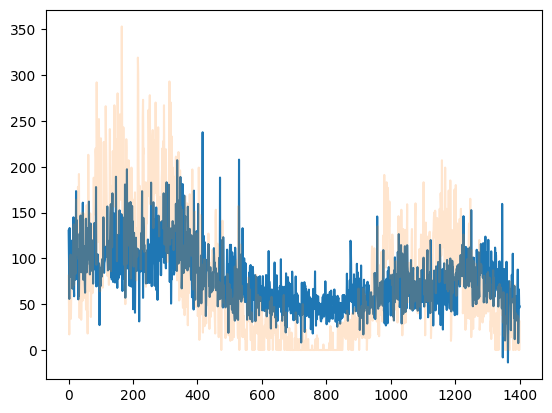

In [ ]:
plt.plot(pred)
plt.plot(y_train.values, alpha =0.2)

In [ ]:
np.mean((pred - y_train)**2)

3214.607382454558

2306.672911886321


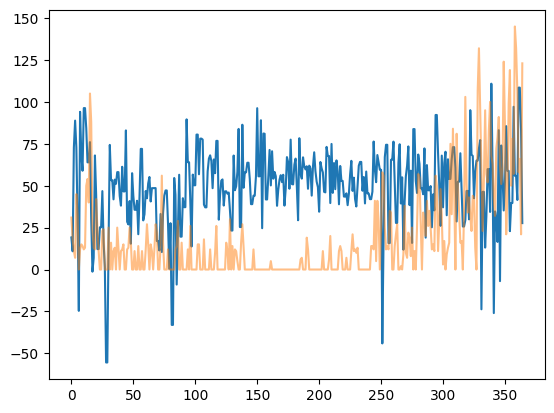

In [ ]:
pred_test = linreg.predict(x_test)
print(np.mean((pred_test - y_test)**2))
plt.plot(pred_test, alpha=1)
plt.plot(y_test.values, alpha=0.5)

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
df = pd.read_csv('data_new.csv')

In [ ]:
import datetime
base = datetime.datetime(1960, 1, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(21915)]
df['index'] = date_list
df = df.rename(columns={"index":"ds", "ans":'y'})

In [ ]:
df[df['y']==0]['y'] += df.rolling(5).mean()[df['y']==0]['y'] 

<ipython-input-4-ede09de5bbdc>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['ds'], dtype='object')
  df[df['y']==0]['y'] += df.rolling(5).mean()[df['y']==0]['y']
<ipython-input-4-ede09de5bbdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['y']==0]['y'] += df.rolling(5).mean()[df['y']==0]['y']


In [ ]:
from prophet import Prophet
s = 11
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.add_seasonality(name='cycle', period=33*365//2, fourier_order=3)
m.fit(df[:-s*365])
future = m.make_future_dataframe(periods=s*365)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpd7s2ut_1/64t1ocg5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd7s2ut_1/rn121561.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87235', 'data', 'file=/tmp/tmpd7s2ut_1/64t1ocg5.json', 'init=/tmp/tmpd7s2ut_1/rn121561.json', 'output', 'file=/tmp/tmpd7s2ut_1/prophet_modelu2004qx1/prophet_model-20230517180322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
pred = m.predict(future)

In [ ]:
import numpy as np
np.sqrt(np.mean((pred.iloc[:-s*365]['yhat'] - df.iloc[:-s*365]['y'])**2))

42.44320619597257

In [ ]:
np.sqrt(np.mean((pred.iloc[-s*365:]['yhat'] - df.iloc[-s*365:]['y'])**2))

112.22252913041473

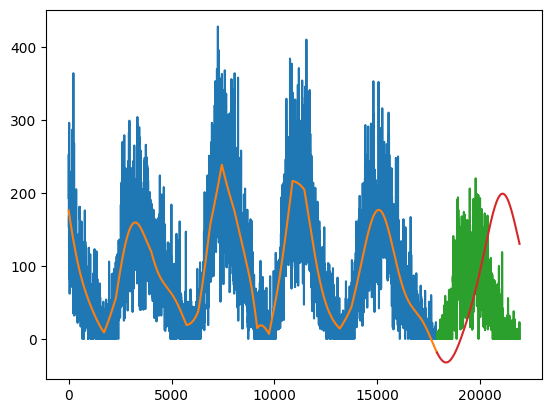

In [ ]:
import matplotlib.pyplot as plt
# pred = m.predict(future)

plt.plot(df.iloc[:-11*365]['y'])
plt.plot(pred.iloc[:-11*365]['yhat'])
plt.plot(df.iloc[-11*365:]['y'])
# plt.plot(pred.iloc[-11*365:]['yhat'])
# pred.iloc[-11*365:]['yhat'] += (np.arange(11*365)**1.3)/1000
plt.plot(pred.iloc[-11*365:]['yhat'])

In [ ]:
pred

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0     1960-01-01  169.534224  117.048119  225.323149   169.534224   
1     1960-01-02  169.466726  117.231210  229.933839   169.466726   
2     1960-01-03  169.399229  121.306637  225.848369   169.399229   
3     1960-01-04  169.331731  117.059196  224.248083   169.331731   
4     1960-01-05  169.264233  119.729547  225.867220   169.264233   
...          ...         ...         ...         ...          ...   
21910 2019-12-27    7.141785 -362.956716  310.738409  -316.379641   
21911 2019-12-28    7.128170 -382.243367  314.614052  -316.537332   
21912 2019-12-29    7.114554 -391.136608  304.340298  -316.695022   
21913 2019-12-30    7.100938 -368.662782  328.593370  -316.852713   
21914 2019-12-31    7.087322 -375.867495  318.781757  -317.010403   

       trend_upper  additive_terms  additive_terms_lower  \
0       169.534224        3.202502              3.202502   
1       169.466726        3.096259              3.096259   
2       169.399229        2.990235              2.990235   
3       169.331731        2.884429              2.884429   
4       169.264233        2.778841              2.778841   
...            ...             ...                   ...   
21910   359.610165      -48.412768            -48.412768   
21911   359.750761      -48.368274            -48.368274   
21912   359.891357      -48.323668            -48.323668   
21913   360.001204      -48.278950            -48.278950   
21914   360.097816      -48.234118            -48.234118   

       additive_terms_upper      cycle  cycle_lower  cycle_upper  \
0                  3.202502   3.202502     3.202502     3.202502   
1                  3.096259   3.096259     3.096259     3.096259   
2                  2.990235   2.990235     2.990235     2.990235   
3                  2.884429   2.884429     2.884429     2.884429   
4                  2.778841   2.778841     2.778841     2.778841   
...                     ...        ...          ...          ...   
21910            -48.412768 -48.412768   -48.412768   -48.412768   
21911            -48.368274 -48.368274   -48.368274   -48.368274   
21912            -48.323668 -48.323668   -48.323668   -48.323668   
21913            -48.278950 -48.278950   -48.278950   -48.278950   
21914            -48.234118 -48.234118   -48.234118   -48.234118   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
21910                   0.0                         0.0   
21911                   0.0                         0.0   
21912                   0.0                         0.0   
21913                   0.0                         0.0   
21914                   0.0                         0.0   

       multiplicative_terms_upper        yhat  
0                             0.0  172.736726  
1                             0.0  172.562986  
2                             0.0  172.389464  
3                             0.0  172.216160  
4                             0.0  172.043074  
...                           ...         ...  
21910                         0.0  -41.270983  
21911                         0.0  -41.240104  
21912                         0.0  -41.209114  
21913                         0.0  -41.178012  
21914                         0.0  -41.146797  

[21915 rows x 16 columns]

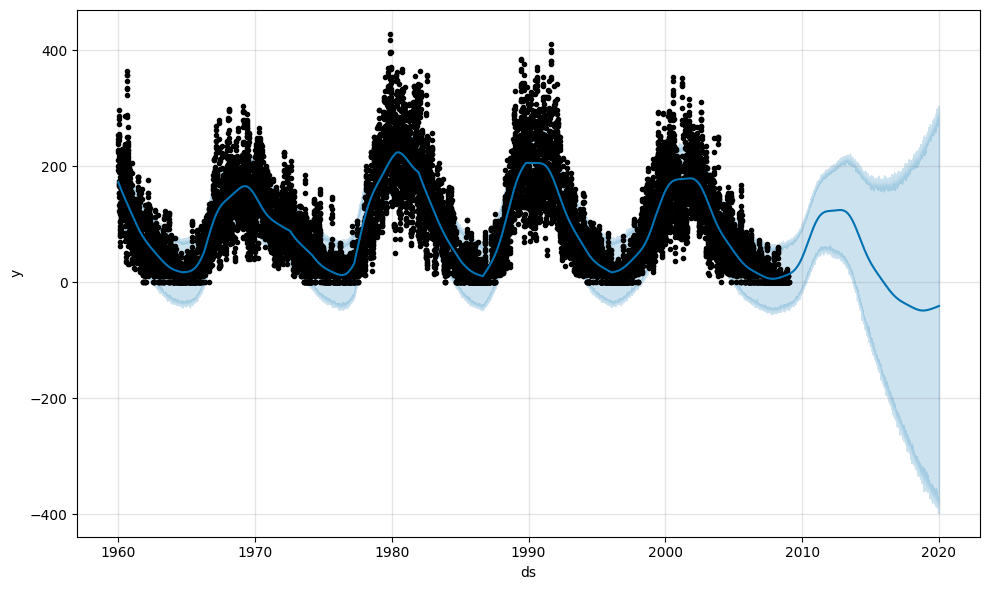

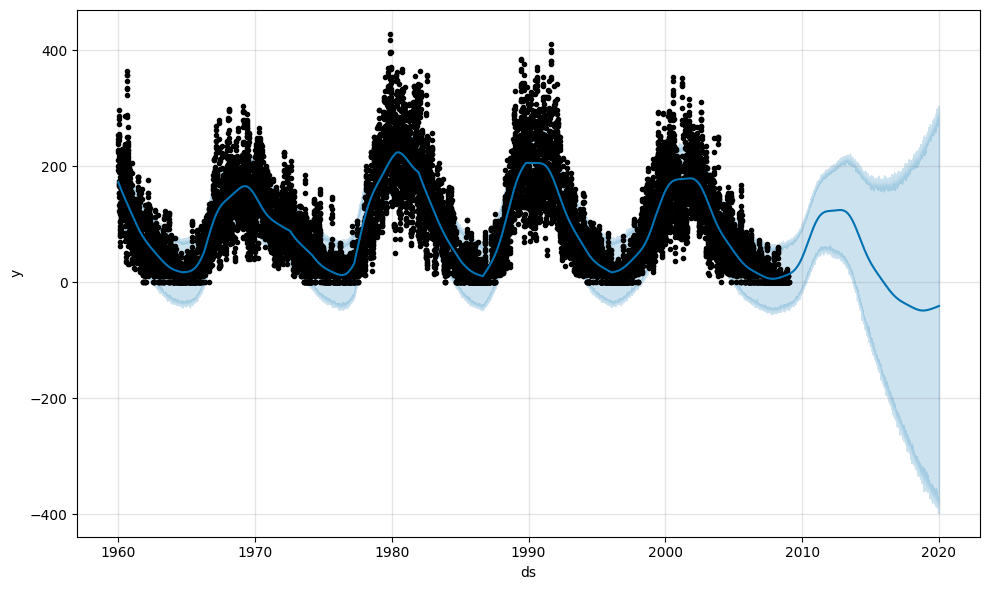

In [ ]:
m.plot(pred)

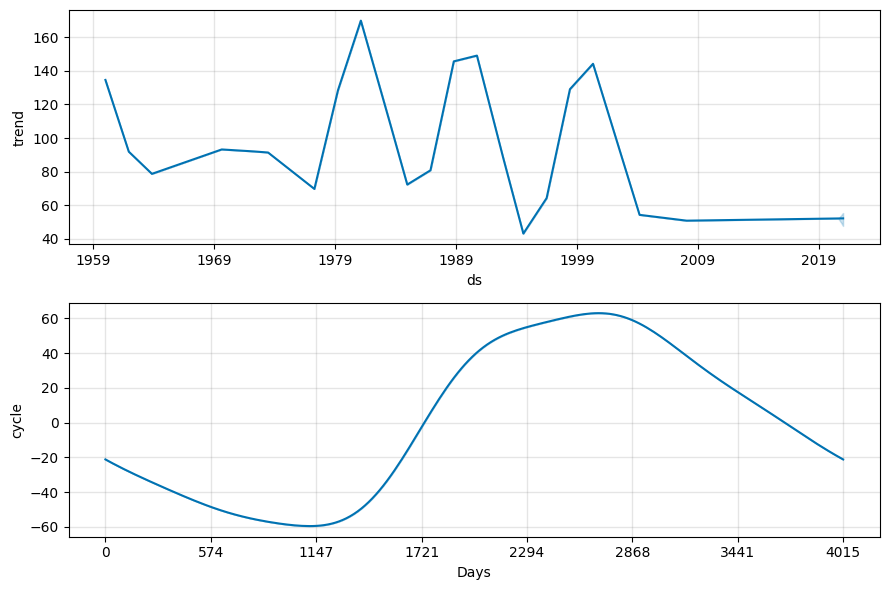

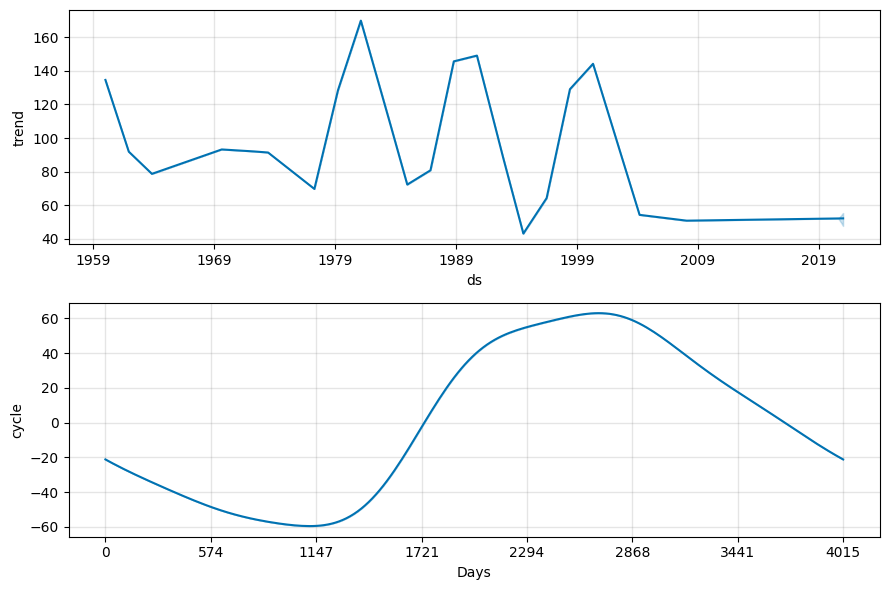

In [ ]:
m.plot_components(pred)

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

SARIMA_model = pm.auto_arima(df.iloc[:-11*365]['y'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=1, max_q=1, # maximum p and q
                      m=11*365, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=1, D = 1,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic


In [ ]:
import pmdarima as pm

ARIMA_model = pm.auto_arima(df.iloc[:-s*365]['y'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

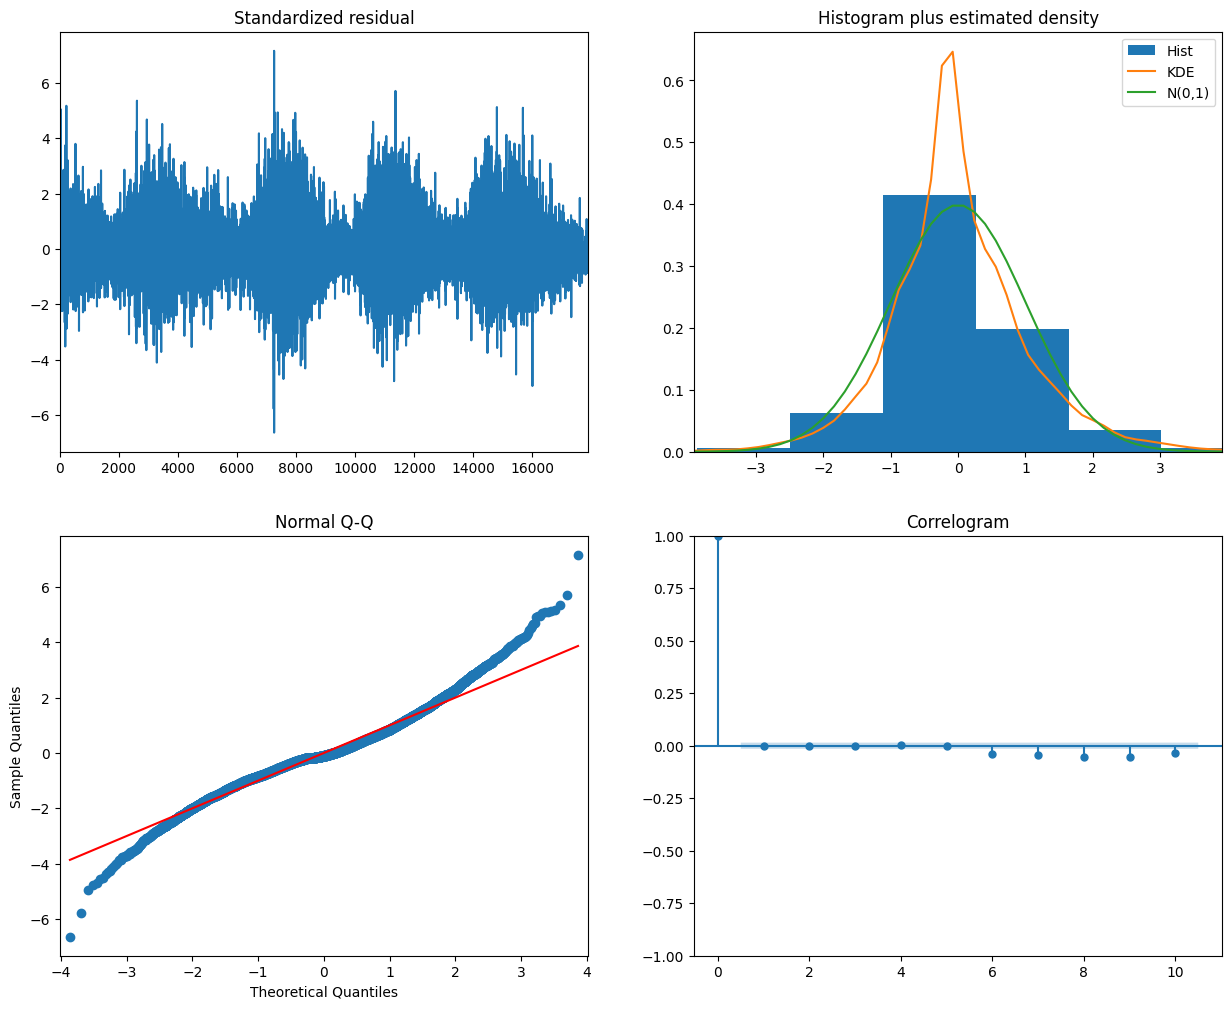

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def forecast(ARIMA_model, periods=s*365):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.iloc[-s*365]['ds'] + pd.DateOffset(days=1), periods = n_periods)

    # make series for plotting purpose
    # fitted_series = pd.Series(fitted, index=index_of_fc)
    # lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    # upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    pred = pd.DataFrame(data=fitted, columns=['pred'])
    pred.index = index_of_fc
    plt.figure(figsize=(15,7))
    plt.plot(df['ds'], df["y"], alpha=0.5)
    plt.plot(pred['pred'])
    # plt.fill_between(lower_series.index, 
    #                 lower_series, 
    #                 upper_series, 
    #                 color='k', alpha=.15)
    plt.title("ARIMA prediction on test data")
    plt.show()
# a = forecast(ARIMA_model)

In [ ]:
import pmdarima as pm
s = 11
SARIMA_model = pm.auto_arima(df.iloc[:-s*365]['y'], start_p=2, start_q=2,
                         test='adf',
                         max_p=2, max_q=2, 
                         m=5, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [ ]:
a = forecast(SARIMA_model)